In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, ttest_rel, ttest_1samp
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import trompy as tp

In [2]:
DATAFOLDER = Path("..\\data")
FIGSFOLDER = Path("..\\figures")
FIGSFOLDER = Path("C:\\Users\\jmc010\\Dropbox\\Publications in Progress\\IPP Giulia paper\\figs")

save_figs = False

def tweak_df(df, session="s4"):

    return (df
            .query("session == @session")
            )

df = pd.read_excel(DATAFOLDER / "metafile_ipp.xlsx", sheet_name="metafile Exp 1")
df = tweak_df(df)

In [3]:
def get_licks_per_solution(row):
    filename = row.medfile
    # print(f"Processing {filename}")

    L, R = tp.medfilereader(DATAFOLDER / filename, vars_to_extract=["b", "e"], remove_var_header=True)

    if "malt" in row.bottleL and "cas" in row.bottleR:
        med_var_malt, med_var_casein = L, R
    elif "malt" in row.bottleR and "cas" in row.bottleL:
        med_var_malt, med_var_casein = R, L
    else:
        raise ValueError("Bottles not found")
    
    return med_var_casein, med_var_malt

def get_pref_per_session(df):

    NR_pref, PR_pref = [], []
    
    for idx, row in df.query("dietgroup == 'NR'").iterrows():
        cas_licks, malt_licks = get_licks_per_solution(row)
        
        NR_pref.append(len(cas_licks) / (len(cas_licks) + len(malt_licks)))
    
    for idx, row in df.query("dietgroup == 'PR'").iterrows():
        cas_licks, malt_licks = get_licks_per_solution(row)
        
        PR_pref.append(len(cas_licks) / (len(cas_licks) + len(malt_licks)))
        
    print(len(NR_pref), len(PR_pref))

    return NR_pref, PR_pref

In [4]:
NR_pref_all, PR_pref_all = [], []
for session in ["s4", "s5", "s6", "s7", "s8"]:
    df = pd.read_excel(DATAFOLDER / "metafile_ipp.xlsx", sheet_name="metafile Exp 1")
    df = tweak_df(df, session=session)
    
    NR_pref, PR_pref = get_pref_per_session(df)
    
    NR_pref_all.append(NR_pref)
    PR_pref_all.append(PR_pref)
    
NR_pref_all = np.array(NR_pref_all)
PR_pref_all = np.array(PR_pref_all)
    

14 14
14 14
14 14
14 14
14 14


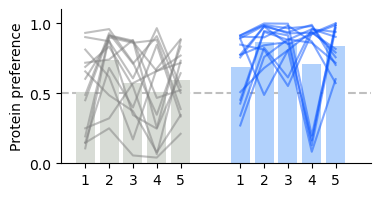

In [5]:
f, ax = plt.subplots(figsize=(4, 2))

NRx = np.arange(1, 6)
PRx = np.arange(7.5, 12.5)

ax.bar(NRx, np.mean(NR_pref_all, axis=1), color="xkcd:light gray", label="NR")
ax.bar(PRx, np.mean(PR_pref_all, axis=1), color="xkcd:powder blue", label="PR")

# ax.boxplot(NR_pref_all.T, positions=NRx, widths=0.5, patch_artist=True, boxprops=dict(facecolor="gray"))
# ax.boxplot(PR_pref_all.T, positions=PRx, widths=0.5, patch_artist=True, boxprops=dict(facecolor="xkcd:electric blue"))

for i in range(np.shape(NR_pref_all)[1]):
    ax.plot(NRx, NR_pref_all[:,i], linestyle="-", color="gray", alpha=0.5)
    ax.plot(PRx, PR_pref_all[:,i], linestyle="-", color="xkcd:electric blue", alpha=0.5)
    # a
    # ax.plot(PRx, PR_pref_all[i], "o", color="xkcd:electric blue", alpha=0.5)

ax.set_ylim(0, 1.1)
ax.set_yticks([0, 0.5, 1])
ax.set_ylabel("Protein preference")

ax.set_xticks([1,2,3,4,5,7.5,8.5,9.5,10.5,11.5],
              labels=[1,2,3,4,5,1,2,3,4,5])

ax.hlines(0.5, 0, 13, linestyle="--", color="gray", zorder=0, alpha=0.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlim(0, 13)

if save_figs:
    f.savefig(FIGSFOLDER / "3A_protein_preference.pdf")


In [6]:
### Stats
data = {
    'subject': np.hstack([np.tile(np.arange(1, len(NR_pref_all[0]) + 1), 5), np.tile(np.arange(15,29), 5)]),
    'diet': np.hstack([np.array(["NR"] * (14*5)), np.array(["PR"] * (14*5))]),
    'day': np.tile(np.repeat(np.arange(1, 6), 14), 2),
    'pref': np.concatenate([tp.flatten_list(NR_pref_all), tp.flatten_list(PR_pref_all)])
}

stats_df = pd.DataFrame(data)

aov = pg.mixed_anova(data=stats_df, dv='pref', subject='subject', within='day', between='diet')

print(aov)

        Source        SS  DF1  DF2        MS          F     p-unc  p-GG-corr  \
0         diet  1.531625    1   26  1.531625  15.490601  0.000553        NaN   
1          day  0.797765    4  104  0.199441   3.685601  0.007564   0.017009   
2  Interaction  0.098375    4  104  0.024594   0.454485  0.768921        NaN   

        np2       eps sphericity   W-spher   p-spher  
0  0.373352       NaN        NaN       NaN       NaN  
1  0.124155  0.682826      False  0.378541  0.003397  
2  0.017180       NaN        NaN       NaN       NaN  


In [7]:
## Statistics

print("Non-restricted")
for idx, day in enumerate(NR_pref_all):
    t, p = ttest_1samp(NR_pref_all[idx], 0.5)
    print(f"Day {idx+1}: t={t:.3f}, p={p:.3f}")
    
print("Protein-restricted")
for idx, day in enumerate(PR_pref_all):
    t, p = ttest_1samp(PR_pref_all[idx], 0.5)
    print(f"Day {idx+1}: t={t:.3f}, p={p:.3f}")

Non-restricted
Day 1: t=0.085, p=0.934
Day 2: t=3.756, p=0.002
Day 3: t=0.974, p=0.348
Day 4: t=0.074, p=0.942
Day 5: t=1.595, p=0.135
Protein-restricted
Day 1: t=3.013, p=0.010
Day 2: t=9.355, p=0.000
Day 3: t=10.237, p=0.000
Day 4: t=2.083, p=0.058
Day 5: t=8.411, p=0.000


### Panel 3B

In [8]:
def get_clusters_per_session(df, dietgroup):

    cas_cluster_num, malt_cluster_num = [], []
    cas_cluster_size, malt_cluster_size = [], []
    
    for idx, row in df.query("dietgroup == @dietgroup").iterrows():
        cas_licks, malt_licks = get_licks_per_solution(row)
        
        cas_lickdata = tp.lickCalc(cas_licks, burstThreshold=0.5, minburstlength=3)
        malt_lickdata = tp.lickCalc(malt_licks, burstThreshold=0.5, minburstlength=3)
        
        cas_cluster_num.append(cas_lickdata["bNum"])
        cas_cluster_size.append(np.mean(cas_lickdata["bLicks"][1:-1]))
        
        malt_cluster_num.append(malt_lickdata["bNum"])
        malt_cluster_size.append(np.mean(malt_lickdata["bLicks"][1:-1]))

    return cas_cluster_num, malt_cluster_num, cas_cluster_size, malt_cluster_size

In [9]:
NR_cas_cluster_num, NR_malt_cluster_num = [], []
PR_cas_cluster_num, PR_malt_cluster_num = [], []
for session in ["s4", "s5", "s6", "s7", "s8"]:
    df = pd.read_excel(DATAFOLDER / "metafile_ipp.xlsx", sheet_name="metafile Exp 1")
    df = tweak_df(df, session=session)
    
    cas_cluster_num, malt_cluster_num, _, _ = get_clusters_per_session(df, "NR")
    
    NR_cas_cluster_num.append(cas_cluster_num)
    NR_malt_cluster_num.append(malt_cluster_num)
    
    cas_cluster_num, malt_cluster_num, _, _ = get_clusters_per_session(df, "PR")
    
    PR_cas_cluster_num.append(cas_cluster_num)
    PR_malt_cluster_num.append(malt_cluster_num)
    
NR_cas_cluster_num = np.array(NR_cas_cluster_num)
NR_malt_cluster_num = np.array(NR_malt_cluster_num)
PR_cas_cluster_num = np.array(PR_cas_cluster_num)
PR_malt_cluster_num = np.array(PR_malt_cluster_num)

c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\num

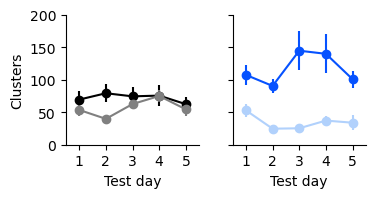

In [10]:
def sem(data, axis=0):
    return np.std(data, axis=axis) / np.sqrt(np.shape(data)[axis])

f, [ax1, ax2] = plt.subplots(ncols = 2, figsize=(4, 2), sharey=True,
                     gridspec_kw={"left": 0.15, "right": 0.90, "top": 0.9, "bottom": 0.25,
                                  "wspace":0.25})

x = np.arange(1, 6)
ax1.errorbar(x, np.mean(NR_cas_cluster_num, axis=1), yerr=sem(NR_cas_cluster_num, axis=1), color="black", label="Cas", marker="o")
ax1.errorbar(x, np.mean(NR_malt_cluster_num, axis=1), yerr=sem(NR_malt_cluster_num, axis=1), color="grey", label="Malt", marker="o")

ax2.errorbar(x, np.mean(PR_cas_cluster_num, axis=1), yerr=sem(PR_cas_cluster_num, axis=1), color="xkcd:electric blue", label="Cas", marker="o")
ax2.errorbar(x, np.mean(PR_malt_cluster_num, axis=1), yerr=sem(PR_malt_cluster_num, axis=1), color="xkcd:powder blue", label="Malt", marker="o")

ax1.set_ylim(0,200)
ax1.set_ylabel("Clusters")


for axis in [ax1, ax2]:
    axis.set_xlim(0.5, 5.5)
    axis.set_xticks([1,2,3,4,5], labels=[1,2,3,4,5])
    axis.set_xlabel("Test day")
    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)

if save_figs:
    f.savefig(FIGSFOLDER / "3B_clusters.pdf")

### Panel 3C

In [11]:
NR_cas_cluster_size, NR_malt_cluster_size = [], []
PR_cas_cluster_size, PR_malt_cluster_size = [], []
for session in ["s4", "s5", "s6", "s7", "s8"]:
    df = pd.read_excel(DATAFOLDER / "metafile_ipp.xlsx", sheet_name="metafile Exp 1")
    df = tweak_df(df, session=session)
    
    _, _, cas_cluster_size, malt_cluster_size = get_clusters_per_session(df, "NR")
    
    NR_cas_cluster_size.append(cas_cluster_size)
    NR_malt_cluster_size.append(malt_cluster_size)
    
    _, _, cas_cluster_size, malt_cluster_size = get_clusters_per_session(df, "PR")
    
    PR_cas_cluster_size.append(cas_cluster_size)
    PR_malt_cluster_size.append(malt_cluster_size)
    
NR_cas_cluster_size = np.array(NR_cas_cluster_size)
NR_malt_cluster_size = np.array(NR_malt_cluster_size)
PR_cas_cluster_size = np.array(PR_cas_cluster_size)
PR_malt_cluster_size = np.array(PR_malt_cluster_size)

PR_malt_cluster_size = np.nan_to_num(PR_malt_cluster_size, nan=0.0)

c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\num

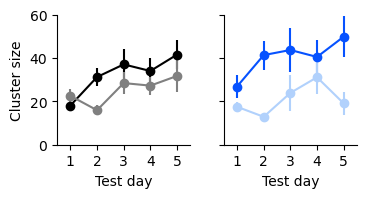

In [12]:
f, [ax1, ax2] = plt.subplots(ncols = 2, figsize=(4, 2), sharey=True,
                     gridspec_kw={"left": 0.15, "right": 0.90, "top": 0.9, "bottom": 0.25,
                                  "wspace":0.25})

x = np.arange(1, 6)
ax1.errorbar(x, np.mean(NR_cas_cluster_size, axis=1), yerr=sem(NR_cas_cluster_size, axis=1), color="black", label="Cas", marker="o")
ax1.errorbar(x, np.mean(NR_malt_cluster_size, axis=1), yerr=sem(NR_malt_cluster_size, axis=1), color="grey", label="Malt", marker="o")

ax2.errorbar(x, np.mean(PR_cas_cluster_size, axis=1), yerr=sem(PR_cas_cluster_size, axis=1), color="xkcd:electric blue", label="Cas", marker="o")
ax2.errorbar(x, np.mean(PR_malt_cluster_size, axis=1), yerr=sem(PR_malt_cluster_size, axis=1), color="xkcd:powder blue", label="Malt", marker="o")

ax1.set_ylim(0,60)
ax1.set_ylabel("Cluster size")


for axis in [ax1, ax2]:
    axis.set_xlim(0.5, 5.5)
    axis.set_xticks([1,2,3,4,5], labels=[1,2,3,4,5])
    axis.set_xlabel("Test day")
    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)

if save_figs:
    f.savefig(FIGSFOLDER / "3C_cluster size.pdf")


In [13]:
## prep for stats in jasp, put data in wide format

data = {
    'subject': np.hstack([np.tile(np.arange(1, len(NR_pref_all[0]) + 1), 10), np.tile(np.arange(15,29), 10)]),
    'diet': np.hstack([np.array(["NR"] * (14*10)), np.array(["PR"] * (14*10))]),
    'day': np.tile(np.repeat(np.arange(1, 6), 14), 4),
    'solution': np.hstack([np.tile("cas", len(tp.flatten_list(NR_cas_cluster_num))),
                           np.tile("malt", len(tp.flatten_list(NR_malt_cluster_num))),
                           np.tile("cas", len(tp.flatten_list(PR_cas_cluster_num))),
                           np.tile("malt", len(tp.flatten_list(PR_malt_cluster_num)))]),
    'cluster_num': np.concatenate([tp.flatten_list(NR_cas_cluster_num), tp.flatten_list(NR_malt_cluster_num), tp.flatten_list(PR_cas_cluster_num), tp.flatten_list(PR_malt_cluster_num)]),
    'cluster_size': np.concatenate([tp.flatten_list(NR_cas_cluster_size), tp.flatten_list(NR_malt_cluster_size), tp.flatten_list(PR_cas_cluster_size), tp.flatten_list(PR_malt_cluster_size)])
}

for key in data.keys():
    print(key, len(data[key]))

df_stats = pd.DataFrame(data)

subject 280
diet 280
day 280
solution 280
cluster_num 280
cluster_size 280


In [14]:
(df_stats
 .astype({"day": str})
 .assign(condition=lambda df_: df_.solution + "_" + df_.day)
 .pivot_table(index=["subject", "diet"], columns="condition", values="cluster_num")
 .reset_index()
 .to_csv(Path("../data") / "clusters_over_days.csv")
)

(df_stats
 .astype({"day": str})
 .assign(condition=lambda df_: df_.solution + "_" + df_.day)
 .pivot_table(index=["subject", "diet"], columns="condition", values="cluster_size")
 .reset_index()
 .to_csv(Path("../data") / "cluster_size_over_days.csv")
)